# 8-puzzle
Implementation and analysis of multiple heuristics

In [ ]:
import numpy as np
import heapq as heap
from queue import PriorityQueue
from collections import deque
import random
import math
import matplotlib.pyplot as plt

A class implementing each state of an eight puzzle. 

The implementation of different **HEURISTICS** is present in this class


> Note: This class can be extended for higher degree tile puzzles

In [ ]:
class State:
    _heuristic = None
    final_state = None

    def __init__(self, state, parent, depth, heuristic = 'manhattan', final_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])):
        self._heuristic = heuristic
        self.final_state = final_state
        state = np.array(state, dtype='u4')
        shape = state.shape

        if len(shape) == 1 and shape[0] == 9:
            state = state.reshape((3, 3))
        elif len(shape) == 2 and shape == (3, 3):
            pass
        else:
            raise ValueError("Invalid input array shape!")

        # save the state
        self.state = state
        self.parent = parent
        self.g = depth
        self.h = self.__heuristic__()
        self.f = self.g + self.h
        # self.f = self.h
        self.__verify__()

        # print(f"f: {self.f} = g: {self.g} + h: {h}")

    def __lt__(self, other):
        return self.f < other.f

    def __verify__(self):
        # checks if the input state is valid
        expected_set = set(range(9))
        flat_matrix = [item for row in self.state for item in row]

        if set(flat_matrix) == expected_set:
            return True
        else:
            return False

    def print(self):
        # print the state
        for row in self.state:
            print("|", end="") # continue the same line
            for num in row:
                print(f" {num} |", end="")
            print() # print a new line

    def __heuristic__(self):
        # set the heuristic function
        if self._heuristic == 'manhattan':
            return self.__manhattan__()
        elif self._heuristic == 'misplaced tiles':
            return self.__misplaced_tiles__()
        elif self._heuristic == 'nilsson sequence':
            return self.__nilsson_sequence_score__()
        elif self._heuristic == 'linear conflict':
            return self.__linear_conflict__()
        else:
            return self.__absolver__()

    # HEURISTIC FUNCTIONS
    # Manhatten
    def __manhattan__(self) -> int:
        sum = 0
        for i in range(3):
            for j in range(3):
                val = self.state[i][j]
                if val:
                    act = np.where(self.final_state == val)
                    sum += abs(i - act[0]) + abs(j - act[1])    
        return sum

    # Misplaced tiles
    def __misplaced_tiles__(self) -> int:
        sum = 0
        for i in range(3):
            for j in range(3):
                val = self.state[i][j]
                if val and ([i], [j]) != np.where(self.final_state == val):
                    sum += 1
        return sum

    

    # Nilsson sequence score
    # Uses the following goal state
    # | 1 | 2 | 3 |
    # | 8 | 0 | 4 |
    # | 7 | 6 | 5 |
    """
    Is not admissible.
    """
    def __nilsson_sequence_score__(self) -> int:
        s = 1 if self.state[(1, 1)] else 0 # Nilsson sequence sum init
        n = 3 # sqrt(N + 1), where N is the number of tiles

        def next(idx):
            # spiral traversal to find the next index
            new_idx = None

            if idx[0] == 0 and idx[1] < n-1:
                new_idx = (idx[0], idx[1] + 1)
            elif idx[0] < n-1 and idx[1] == n-1:
                new_idx = (idx[0] + 1, idx[1])
            elif idx[0] == n-1 and idx[1] > 0:
                new_idx = (idx[0], idx[1] - 1)
            elif idx[0] > 0 and idx[1] == 0:
                new_idx = (idx[0] - 1, idx[1])

            return new_idx      

        cur_idx = (0, 0)
        for _ in range(n**2-1):
            nxt_idx = next(cur_idx)

            cur_val = self.state[cur_idx]
            if cur_val:
                nxt_val = self.state[nxt_idx]
                # print(f"cur_val: {cur_val}, next_val: {nxt_val}")
                if cur_val + 1 != nxt_val or not(cur_val == 8 and nxt_val == 0):
                    s += 2
            cur_idx = nxt_idx
        
        return self.__manhattan__()+3*s

    """
    Jack Mostow and Armand E. Prieditis
    ABSOLVER
    1. REPRESENTATION: A problem class is represented in STRIPES-style.
    2. ABSTRACTION: Some of the preconditions present are dropped to calculate the heuristic.
    3. OPTIMIZATION: Optimizations are added to improve the performance of the heuristic and impart admissibility

    Some of the derived heuristics include:
    - Manhattan Distance (Implemented)
    - n-Swap
    - Misplaced tiles (Implemented)
    - Euclidean distance
    """
    def __absolver__(self):
        if self._heuristic == 'nSwap' or self._heuristic == 'gasching':
            return self.__nSwap__()
        elif self._heuristic == 'euclidean':
            return self.__euclidean__()
        else:
            raise NameError("Undefined heuristic.")
        

    # relaxing adjacency constraint
    def __nSwap__(self): # also known as gasching heuristic
        n = 3
        state = self.state.copy()

        def max_manhattan():
            # returns the position of the tile with maximum manhattan distance
            ans = None
            dist = 0
            for i in range(n):
                for j in range(n):
                    if state[i][j]:
                        act = np.where(self.final_state == state[i][j])
                        val = abs(i - act[0]) + abs(j - act[1])
                        if val > dist:
                            ans = (i, j)
            return ans

        zero_pos = np.where(self.state == 0)
        moves = 0

        while not np.array_equal(state, self.final_state):
            val = self.final_state[zero_pos]
            val_pos = None
            # print(val)
            if val:
                val_pos = np.where(state == val)
                # print("Different position")

            else:
                # choose the val which has maximum manhattan distance
                val_pos = max_manhattan()
                # print(f"Equal zeros.")              
                
            # print(f"zero_pos: {zero_pos}, val_pose: {val_pos}")
            state[val_pos], state[zero_pos] = state[zero_pos], state[val_pos]
            # self.print(state)
            zero_pos = val_pos
            moves += 1
        return moves

    def __euclidean__(self):
        # Both euclidean and manhattan distances are based on geometrical knowledge
        n = 3
        sum = 0
        for i in range(n):
            for j in range(n):
                val = self.state[i][j]
                if val:
                    act = np.where(self.final_state == val)
                    dist = math.hypot(abs(i - act[0]), abs(j - act[1]))    
                    sum += dist
        return sum

    """
    Hansson's method: The Linear conflict (Extension for Manhattan distance)
    While in manhattan distance, a tile can move over other tiles present in its way;
    In linear-conflict methodology, for two tiles to cross each other (if in conflict),
    a minimum addition of two steps is required.
    The Heuristic is admissible as it does not exceed the actual cost to the goal.
    """
    def __linear_conflict__(self):
        n = 3 # sqrt(N + 1), where N is the number of tiles
        manhattan_distance = 0
        for i in range(n):
            for j in range(n):
                val = self.state[i, j]
                if val:
                    goal_position = np.where(self.final_state == val)
                    manhattan_distance += abs(i - goal_position[0][0]) + abs(j - goal_position[1][0])
                    if i == goal_position[0][0] and j != goal_position[1][0]:
                        for k in range(j+1, n):
                            if self.state[i,k] in self.final_state[i] and self.state[i,j] in self.final_state[i]:
                                manhattan_distance += 2
                                # break
                    elif i != goal_position[0][0] and j == goal_position[1][0]:
                        for k in range(i+1, n):
                            if self.state[k,j] in self.final_state[:,j] and self.state[i,j] in self.final_state[:,j]:
                                manhattan_distance += 2
                                # break
        return manhattan_distance

        # def rowLoc(row, query) -> int:
        #     for j in range(n):
        #         if query == self.final_state[row][j]:
        #             return j
        #     return -1

        # for i in range(n): # row
            
        #     for k in range(n): # each element in row
        #         # if (i, k) is in goal state row, get the goal state location
        #         val_k = self.state[i][k]
        #         if val_k:
        #             val_k_goal = rowLoc(i, val_k)
        #             if val_k_goal != -1:
        #                 for j in range(k+1, n): # j lies on the right of k
        #                     val_j = self.state[i][j]
        #                     if val_j:
        #                         val_j_goal = rowLoc(i, val_j)
        #                         # print(f"working row: {i}, val_k:{val_k}, val_k_goal:{val_k_goal}, val_j:{val_j}, val_j_goal:{val_j_goal}")
        #                         if val_j_goal != -1 and val_j_goal < val_k_goal: # the goal position of j must be before the goal position of k
        #                             lc += 1
        
        # def colLoc(col, query) -> int:
        #     for j in range(n):
        #         if query == self.final_state[j][col]:
        #             return j
        #     return -1

        # for i in range(n): # column

        #     for k in range(n):
        #         # if (k, i) is in goal state row, get the goal state location
        #         val_k = self.state[k][i]
        #         if val_k:
        #             val_k_goal = colLoc(i, val_k)
        #             if val_k_goal != -1:

        #                 for j in range(k+1, n):
        #                     val_j = self.state[j][i]
        #                     if val_j:
        #                         val_j_goal = colLoc(i, val_j)
        #                         # print(f"working col: {i}, val_k:{val_k}, val_k_goal:{val_k_goal}, val_j:{val_j}, val_j_goal:{val_j_goal}")
        #                         if val_j_goal != -1 and val_j_goal < val_k_goal:
        #                             lc += 1
        # # print(f"lc:{lc} manhattan:{self.__manhattan__()}")
        # return lc * 2 + self.__manhattan__()

#### Test codes
A check for each heuristic

In [ ]:
myState1 = State(np.array([[3, 1, 5], [7, 4, 0], [2, 8, 6]]), None, 0)
print(myState1.f)

[11]


In [ ]:
myState2 = State(np.array([[3, 1, 5], [7, 4, 0], [2, 8, 6]]), None, 0, 'nilsson sequence', np.array([[1, 2, 3], [8, 0, 4], [7, 6, 5]]))
print(myState2.f)

[58]


In [ ]:
myState3 = State(np.array([[2, 7, 0], [5, 4, 3], [8, 1, 6]]), None, 0, 'linear conflict', np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))
print(myState3.f)

26


In [ ]:
myState3 = State(np.array([[0, 2, 1], [7, 4, 5], [6, 3, 8]]), None, 0, 'linear conflict', np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))
print(myState3.f)

8


In [ ]:
myState4 = State(np.array([[7, 2, 3], [5, 0, 6], [8, 4, 1]]), None, 0, 'nSwap', np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))
print(myState4.f)

9


## Eight Puzzle Design
A class implementing A* search to solve 8Puzzle problem.
The arguments being: *initial state*, *final_state*, *heuristic_function*

In [ ]:
class EightPuzzle:

    def __init__(self, initial_state, final_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]]), heuristic = 'manhattan', show_states = False):
        self.initial_state = initial_state
        self.final_state = final_state
        self.heuristic = heuristic
        self.show_state(self.initial_state)
        self.states = 0
        self.show_states = show_states
        
    def solve(self):
        start_state = State(self.initial_state, None, 0, self.heuristic)
        heap = PriorityQueue()
        heap.put(start_state)
        visited = set()
        visited.add(str(start_state.state))
        # limit the computation to 5000 states
        while heap and self.states < 5000:
            new_state = heap.get()
            
            if np.array_equal(new_state.state, self.final_state):
                self.get_path(new_state)
                print(f"completed! States generated: {self.states}")
                return new_state.g

            # print states along with cost function 
            if self.show_states:
                print(f"f:{new_state.f} = g:{new_state.g} + h:{new_state.h}")
                self.show_state(new_state.state)
            
            for state in self.__get_children__(new_state.state):
                if str(state) not in visited:
                    self.states += 1
                    visited.add(str(state))
                    child = State(state, new_state, new_state.g + 1, self.heuristic)
                    heap.put(child)
        print("No solution in 5000 states!")

    def get_path(self, state):
        stack = deque()
        while state.parent:
            stack.append(state.state)
            # self.show_state(state.state)
            state = state.parent
        # stack.append(self.initial_state)
        # self.show_state(self.initial_state)
        while stack:
            self.show_state(stack.pop())

    def show_state(self, state):
        # print the state
        for i in range(3):
            print("|", end="") # continue the same line
            for j in range(3):
                num = state[i][j]
                print(f" {num} |", end="")
            print() # print a new line
        print()
    
    def __get_children__(self, state):
        children = []
        # get the index of zero
        zero = np.where(state == 0)
        for x, y in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            i = zero[0] + x
            j = zero[1] + y
            if 0 <= i < 3 and 0 <= j < 3:
                child = state.copy()
                child[zero], child[(i, j)] = child[(i, j)], child[zero]
                children.append(child)
        return children

    def get_states(self):
        return self.states

## 8-puzzle implementation

**State:**  

||||
|--|--|--|
| 4 | 6 | 2 |                            
| 7 | 3 | 1 |
| 0 | 5 | 8 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 8 | 0 | 4 |
| 7 | 6 | 5 |

**Heuristic:** *Manhattan distance*

To calculate the Manhattan distance for a given tile, you simply add the horizontal distance and vertical distance between its current position and its goal position. The total heuristic value is the sum of Manhattan distances for all tiles in the puzzle.

In [ ]:
ep1 = EightPuzzle([[4, 6, 2], [7, 3, 1], [0, 5, 8]], final_state=[[1, 2, 3], [4, 5, 6], [7, 8, 0]], heuristic='manhattan')
# solve 8 puzzle
ep1.solve()

| 4 | 6 | 2 |
| 7 | 3 | 1 |
| 0 | 5 | 8 |

| 4 | 6 | 2 |
| 0 | 3 | 1 |
| 7 | 5 | 8 |

| 4 | 6 | 2 |
| 3 | 0 | 1 |
| 7 | 5 | 8 |

| 4 | 6 | 2 |
| 3 | 1 | 0 |
| 7 | 5 | 8 |

| 4 | 6 | 0 |
| 3 | 1 | 2 |
| 7 | 5 | 8 |

| 4 | 0 | 6 |
| 3 | 1 | 2 |
| 7 | 5 | 8 |

| 4 | 1 | 6 |
| 3 | 0 | 2 |
| 7 | 5 | 8 |

| 4 | 1 | 6 |
| 0 | 3 | 2 |
| 7 | 5 | 8 |

| 0 | 1 | 6 |
| 4 | 3 | 2 |
| 7 | 5 | 8 |

| 1 | 0 | 6 |
| 4 | 3 | 2 |
| 7 | 5 | 8 |

| 1 | 3 | 6 |
| 4 | 0 | 2 |
| 7 | 5 | 8 |

| 1 | 3 | 6 |
| 4 | 2 | 0 |
| 7 | 5 | 8 |

| 1 | 3 | 0 |
| 4 | 2 | 6 |
| 7 | 5 | 8 |

| 1 | 0 | 3 |
| 4 | 2 | 6 |
| 7 | 5 | 8 |

| 1 | 2 | 3 |
| 4 | 0 | 6 |
| 7 | 5 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 0 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 8 | 0 |

completed! States generated: 151


16

**State:**  

||||
|--|--|--|
| 6 | 8 | 0 |                            
| 2 | 5 | 3 |
| 1 | 4 | 7 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |
| 7 | 8 | 0 |

**Heuristic:** *Misplaced tiles*

The misplaced tiles heuristic is a simple heuristic that counts the number of tiles that are in the wrong position in the puzzle. It is calculated by comparing the current state of the puzzle to the goal state and counting the number of tiles that are in different positions. 

In [ ]:
ep2 = EightPuzzle([[6, 8, 0], [2, 5, 3], [1, 4, 7]], final_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]], heuristic = 'misplaced tiles')
# solve 8 puzzle
ep2.solve()

| 6 | 8 | 0 |
| 2 | 5 | 3 |
| 1 | 4 | 7 |

| 6 | 0 | 8 |
| 2 | 5 | 3 |
| 1 | 4 | 7 |

| 0 | 6 | 8 |
| 2 | 5 | 3 |
| 1 | 4 | 7 |

| 2 | 6 | 8 |
| 0 | 5 | 3 |
| 1 | 4 | 7 |

| 2 | 6 | 8 |
| 5 | 0 | 3 |
| 1 | 4 | 7 |

| 2 | 6 | 8 |
| 5 | 3 | 0 |
| 1 | 4 | 7 |

| 2 | 6 | 0 |
| 5 | 3 | 8 |
| 1 | 4 | 7 |

| 2 | 0 | 6 |
| 5 | 3 | 8 |
| 1 | 4 | 7 |

| 2 | 3 | 6 |
| 5 | 0 | 8 |
| 1 | 4 | 7 |

| 2 | 3 | 6 |
| 0 | 5 | 8 |
| 1 | 4 | 7 |

| 2 | 3 | 6 |
| 1 | 5 | 8 |
| 0 | 4 | 7 |

| 2 | 3 | 6 |
| 1 | 5 | 8 |
| 4 | 0 | 7 |

| 2 | 3 | 6 |
| 1 | 5 | 8 |
| 4 | 7 | 0 |

| 2 | 3 | 6 |
| 1 | 5 | 0 |
| 4 | 7 | 8 |

| 2 | 3 | 0 |
| 1 | 5 | 6 |
| 4 | 7 | 8 |

| 2 | 0 | 3 |
| 1 | 5 | 6 |
| 4 | 7 | 8 |

| 0 | 2 | 3 |
| 1 | 5 | 6 |
| 4 | 7 | 8 |

| 1 | 2 | 3 |
| 0 | 5 | 6 |
| 4 | 7 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 0 | 7 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 0 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 8 | 0 |

completed! States generated: 3971


20

**State:**  

||||
|--|--|--|
| 1 | 0 | 3 |                            
| 4 | 2 | 5 |
| 8 | 7 | 6 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 8 | 0 | 4 |
| 7 | 6 | 5 |

**Heuristic:** *Nilsson Sequence*

Nilsson heuristic is a combination of Manhattan distance heuristic and sequence score heuristic. In this heuristic, the sum of Manhattan distance of each tile to its goal position is calculated, and then a sequence score is added to the Manhattan distance for each pair of tiles that are in their goal row or column, but not in the correct relative order. This sequence score represents the number of times the two tiles have to be exchanged in order to be in the correct order. The sum of the Manhattan distance and sequence score is used as the heuristic value. Nilsson heuristic is admissible, meaning it never overestimates the cost of reaching the goal state, and it takes into account more information than Manhattan distance or misplaced tiles heuristics alone, leading to a more informed search.

In [ ]:
ep3 = EightPuzzle([[1, 0, 3], [4, 2, 5], [8, 7, 6]], heuristic = 'nilsson sequence', final_state=[[1, 2, 3], [8, 0, 4], [7, 6, 5]])
# solve 8 puzzle
ep3.solve()

| 1 | 0 | 3 |
| 4 | 2 | 5 |
| 8 | 7 | 6 |

| 1 | 2 | 3 |
| 4 | 0 | 5 |
| 8 | 7 | 6 |

| 1 | 2 | 3 |
| 0 | 4 | 5 |
| 8 | 7 | 6 |

| 1 | 2 | 3 |
| 8 | 4 | 5 |
| 0 | 7 | 6 |

| 1 | 2 | 3 |
| 8 | 4 | 5 |
| 7 | 0 | 6 |

| 1 | 2 | 3 |
| 8 | 4 | 5 |
| 7 | 6 | 0 |

| 1 | 2 | 3 |
| 8 | 4 | 0 |
| 7 | 6 | 5 |

| 1 | 2 | 3 |
| 8 | 0 | 4 |
| 7 | 6 | 5 |

completed! States generated: 484


7

**State:**  

||||
|--|--|--|
| 1 | 2 | 6 |                            
| 5 | 0 | 8 |
| 4 | 7 | 3 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |
| 7 | 8 | 0 |

**Heuristic:** *n Swap*

This heuristic measures the number of adjacent pairs of tiles in the current state that are not in their correct positions and require swapping to reach the goal state.

In [ ]:
ep4 = EightPuzzle([[1, 2, 6], [5, 0, 8], [4, 7, 3]], heuristic = 'nSwap', final_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]])
# solve 8 puzzle
ep4.solve()

| 1 | 2 | 6 |
| 5 | 0 | 8 |
| 4 | 7 | 3 |

| 1 | 2 | 6 |
| 0 | 5 | 8 |
| 4 | 7 | 3 |

| 1 | 2 | 6 |
| 4 | 5 | 8 |
| 0 | 7 | 3 |

| 1 | 2 | 6 |
| 4 | 5 | 8 |
| 7 | 0 | 3 |

| 1 | 2 | 6 |
| 4 | 5 | 8 |
| 7 | 3 | 0 |

| 1 | 2 | 6 |
| 4 | 5 | 0 |
| 7 | 3 | 8 |

| 1 | 2 | 0 |
| 4 | 5 | 6 |
| 7 | 3 | 8 |

| 1 | 0 | 2 |
| 4 | 5 | 6 |
| 7 | 3 | 8 |

| 1 | 5 | 2 |
| 4 | 0 | 6 |
| 7 | 3 | 8 |

| 1 | 5 | 2 |
| 4 | 3 | 6 |
| 7 | 0 | 8 |

| 1 | 5 | 2 |
| 4 | 3 | 6 |
| 7 | 8 | 0 |

| 1 | 5 | 2 |
| 4 | 3 | 0 |
| 7 | 8 | 6 |

| 1 | 5 | 2 |
| 4 | 0 | 3 |
| 7 | 8 | 6 |

| 1 | 0 | 2 |
| 4 | 5 | 3 |
| 7 | 8 | 6 |

| 1 | 2 | 0 |
| 4 | 5 | 3 |
| 7 | 8 | 6 |

| 1 | 2 | 3 |
| 4 | 5 | 0 |
| 7 | 8 | 6 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 8 | 0 |

completed! States generated: 841


16

**State:**  

||||
|--|--|--|
| 0 | 1 | 6 |                            
| 2 | 5 | 8 |
| 4 | 3 | 7 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |
| 7 | 8 | 0 |

**Heuristic:** *euclidean*

Euclidean distance is useful when the exact location of the points matters, while Manhattan distance is useful when movement is restricted to the grid-like paths.

In [ ]:
ep5 = EightPuzzle([[0, 1, 6], [2, 5, 8], [4, 3, 7]], heuristic = 'euclidean', final_state = [[1, 2, 3], [4, 5, 6], [7, 8, 0]])
# solve 8 puzzle
ep5.solve()

| 0 | 1 | 6 |
| 2 | 5 | 8 |
| 4 | 3 | 7 |

| 1 | 0 | 6 |
| 2 | 5 | 8 |
| 4 | 3 | 7 |

| 1 | 5 | 6 |
| 2 | 0 | 8 |
| 4 | 3 | 7 |

| 1 | 5 | 6 |
| 2 | 3 | 8 |
| 4 | 0 | 7 |

| 1 | 5 | 6 |
| 2 | 3 | 8 |
| 4 | 7 | 0 |

| 1 | 5 | 6 |
| 2 | 3 | 0 |
| 4 | 7 | 8 |

| 1 | 5 | 0 |
| 2 | 3 | 6 |
| 4 | 7 | 8 |

| 1 | 0 | 5 |
| 2 | 3 | 6 |
| 4 | 7 | 8 |

| 1 | 3 | 5 |
| 2 | 0 | 6 |
| 4 | 7 | 8 |

| 1 | 3 | 5 |
| 0 | 2 | 6 |
| 4 | 7 | 8 |

| 1 | 3 | 5 |
| 4 | 2 | 6 |
| 0 | 7 | 8 |

| 1 | 3 | 5 |
| 4 | 2 | 6 |
| 7 | 0 | 8 |

| 1 | 3 | 5 |
| 4 | 2 | 6 |
| 7 | 8 | 0 |

| 1 | 3 | 5 |
| 4 | 2 | 0 |
| 7 | 8 | 6 |

| 1 | 3 | 0 |
| 4 | 2 | 5 |
| 7 | 8 | 6 |

| 1 | 0 | 3 |
| 4 | 2 | 5 |
| 7 | 8 | 6 |

| 1 | 2 | 3 |
| 4 | 0 | 5 |
| 7 | 8 | 6 |

| 1 | 2 | 3 |
| 4 | 5 | 0 |
| 7 | 8 | 6 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 8 | 0 |

completed! States generated: 469


18

**State:**  

||||
|--|--|--|
| 3 | 8 | 0 |                            
| 6 | 1 | 7 |
| 4 | 2 | 5 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |
| 7 | 8 | 0 |

**Heuristic:** *Linear conflict*

Linear Conflict takes into account additional conflicts that may occur when two tiles need to swap positions in order to reach their final position. These conflicts can create additional moves that Manhattan distance does not account for, so Linear Conflict is considered to be a more informed heuristic than Manhattan distance.

In [ ]:
ep6 = EightPuzzle([[1, 4, 2], [6, 3, 5], [7, 8, 0]], heuristic = 'linear conflict', final_state=[[0, 1, 2], [3, 4, 5], [6, 7, 8]])
# solve 8 puzzle
ep6.solve()

| 1 | 4 | 2 |
| 6 | 3 | 5 |
| 7 | 8 | 0 |

| 1 | 4 | 2 |
| 6 | 3 | 5 |
| 7 | 0 | 8 |

| 1 | 4 | 2 |
| 6 | 3 | 5 |
| 0 | 7 | 8 |

| 1 | 4 | 2 |
| 0 | 3 | 5 |
| 6 | 7 | 8 |

| 1 | 4 | 2 |
| 3 | 0 | 5 |
| 6 | 7 | 8 |

| 1 | 0 | 2 |
| 3 | 4 | 5 |
| 6 | 7 | 8 |

| 0 | 1 | 2 |
| 3 | 4 | 5 |
| 6 | 7 | 8 |

completed! States generated: 1924


6

## Comparision
1. Misplaced Tiles
2. Manhattan Distance
3. Euclidean Distance
4. n-Swap
5. Linear Conflict

> **Note:**  
> Nilsson's heuristic a.k.a. `sequence score` works on spiral type of goal state. An example of Nilsson's heurisstic is implemented above.

**State:**  

||||
|--|--|--|
| 5 | 1 | 3 |                            
| 6 | 0 | 7 |
| 2 | 8 | 4 |

**Goal:**

||||
|--|--|--|
| 1 | 2 | 3 |                            
| 4 | 5 | 6 |
| 7 | 8 | 0 |

*Implementing all heuristics*

In [ ]:
start = [[5, 1, 3], [6, 0, 7], [2, 8, 4]]
goal = [[1, 2, 3], [4, 5, 6], [7, 8, 0]]

# create labels of heuristics
labels = ['misplaced tiles', 'manhattan', 'euclidean', 'nSwap', 'linear conflict']
states = []
cost = []

# change to TRUE to examine the states
view_states = False

for label in labels:
    print(f"using {label} heuristic...")
    eight_puzzle = EightPuzzle(start, heuristic = label, final_state = goal, show_states = view_states)
    cost.append(eight_puzzle.solve())
    states.append(eight_puzzle.get_states())
    print()

using misplaced tiles heuristic...
| 5 | 1 | 3 |
| 6 | 0 | 7 |
| 2 | 8 | 4 |

| 5 | 1 | 3 |
| 6 | 8 | 7 |
| 2 | 0 | 4 |

| 5 | 1 | 3 |
| 6 | 8 | 7 |
| 2 | 4 | 0 |

| 5 | 1 | 3 |
| 6 | 8 | 0 |
| 2 | 4 | 7 |

| 5 | 1 | 3 |
| 6 | 0 | 8 |
| 2 | 4 | 7 |

| 5 | 1 | 3 |
| 0 | 6 | 8 |
| 2 | 4 | 7 |

| 5 | 1 | 3 |
| 2 | 6 | 8 |
| 0 | 4 | 7 |

| 5 | 1 | 3 |
| 2 | 6 | 8 |
| 4 | 0 | 7 |

| 5 | 1 | 3 |
| 2 | 6 | 8 |
| 4 | 7 | 0 |

| 5 | 1 | 3 |
| 2 | 6 | 0 |
| 4 | 7 | 8 |

| 5 | 1 | 3 |
| 2 | 0 | 6 |
| 4 | 7 | 8 |

| 5 | 1 | 3 |
| 0 | 2 | 6 |
| 4 | 7 | 8 |

| 0 | 1 | 3 |
| 5 | 2 | 6 |
| 4 | 7 | 8 |

| 1 | 0 | 3 |
| 5 | 2 | 6 |
| 4 | 7 | 8 |

| 1 | 2 | 3 |
| 5 | 0 | 6 |
| 4 | 7 | 8 |

| 1 | 2 | 3 |
| 0 | 5 | 6 |
| 4 | 7 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 0 | 7 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 0 | 8 |

| 1 | 2 | 3 |
| 4 | 5 | 6 |
| 7 | 8 | 0 |

completed! States generated: 2147

using manhattan heuristic...
| 5 | 1 | 3 |
| 6 | 0 | 7 |
| 2 | 8 | 4 |

| 5 | 1 | 3 |
| 6 | 8 | 7 |
| 2 | 0 | 4 |

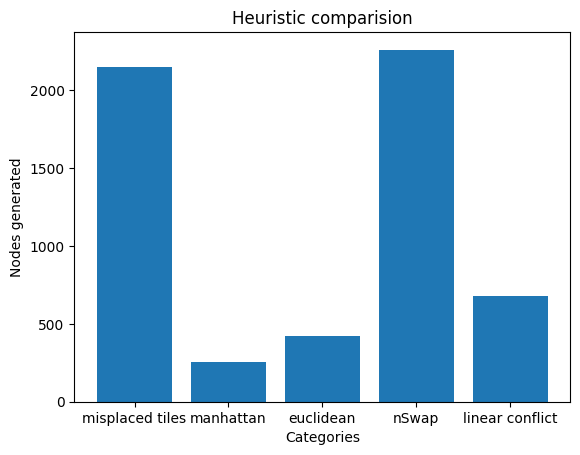

In [ ]:
# Create bar chart
plt.bar(labels, states)

# Set chart title and axis labels
plt.title('Heuristic comparision')
plt.xlabel('Categories')
plt.ylabel('Nodes generated')

# Show chart
plt.show()

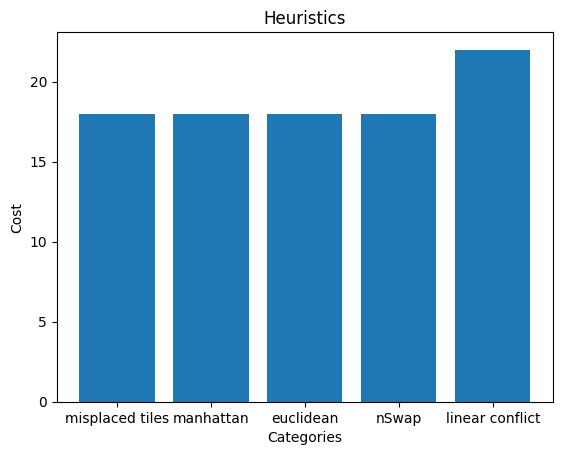

In [ ]:
plt.bar(labels, cost)

plt.title('Heuristics')
plt.xlabel('Categories')
plt.ylabel('Cost')

# Show chart
plt.show()

**Conclusion:**  
The optimal path determined is the same except for the `linear conflict` heuristic. The reason being that it is not admissible. Hence, it ends up getting larger path to the goal.